In [39]:
import math
import random
from typing import Dict

import requests as r
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt

In [8]:
# VW minimizes loss/cost, therefore we will pass cost as -reward
USER_LIKED_TEMPERATURE = -1.0
USER_DISLIKED_TEMPERATURE = 0.0

## Simulate reward

In the real world we will have to learn the room temperature preferences as we observe the interactions between the proposed temperature for each room and the one selected by the people living in the house. Since this is a simulation we will have to define the preference profile for each room. The reward that we provide to the learner will follow this preference profile. Our hope is to see if the learner can take better and better decisions as we see more samples which in turn means we are maximizing the reward.

We will also modify the reward function in a few different ways and see if the CB learner picks up the changes. We will compare the TR with and without learning.

VW minimizes the cost, which is defined as -reward. Therefore, we will pass the cost associated to each chosen action to VW.


The reward function below specifies that we want the living room to be cold in the morning but warm in the afternoon. In reverse, we prefer the bedroom to be warm in the morning and cold in the afternoon. It looks dense but we are just simulating our hypothetical world in the format of the feedback the learner understands: cost. If the learner recommends a temperature that aligns with the reward function, we give a positive reward. Max reward is -1.0, min reward is 0 since VW learns in terms of cost, so we return a negative reward. In our simulated world this is the difference between the temperature recommended and the temperature chosen. If the difference is smaller than 5 degrees then we give a reward to the thermostat. This is a steep cost function.

In [35]:
def get_cost(context, temperature):
    if context["room"] == "Living Room":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            selected_temperature = random.uniform(25, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    elif context["room"] == "Bedroom":
        if context["time_of_day"] == "morning":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(22, 29)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        elif context["time_of_day"] == "afternoon":
            # randomly pick a temperature in this range
            selected_temperature = random.uniform(15, 18)
            # the absolute difference between selected temperature and proposed temperature
            if math.fabs(selected_temperature - temperature) < 5.0:
                return USER_LIKED_TEMPERATURE
            else:
                return USER_DISLIKED_TEMPERATURE
        else:
            return USER_DISLIKED_TEMPERATURE
    else:
        return USER_DISLIKED_TEMPERATURE

# Test requesting

In [13]:
def make_context(room: str, time_of_day: str) -> Dict[str, str]:
    return {"room": room, "time_of_day": time_of_day}

In [23]:
def make_label(action: float, cost: float, pdf_value: float) -> Dict[str, float]:
    return {"action": action, "cost": cost, "pdf_value": pdf_value}

In [14]:
host = 'http://192.168.1.3:1337'

In [17]:
r.get(host+'/time').text

'2022-06-12 16:04:39.154890'

In [22]:
r.post(host+'/predict', json=make_context('Living Room', 'morning')).json()

{'action': 3.2255001068115234, 'pdf_value': 0.22812499105930328}

In [27]:
r.post(
    host+'/update',
    json={
        'context': make_context('Living Room', 'morning'),
        'label': make_label(action=3.22, cost=0, pdf_value=0.228),
    },
).json()

{'status': 'OK'}

# Run coninuous simulation

In [36]:
rewards = []
for _ in tqdm(range(10_000)):
    context = make_context(
        room=random.choice(["Living Room", "Bedroom"]),
        time_of_day=random.choice(["morning", "afternoon"]),
    )
    prediction = r.post(host+'/predict', json=context).json()

    cost = get_cost(context, prediction['action'])

    r.post(
        host+'/update',
        json={
            'context': context,
            'label': make_label(
                prediction['action'],
                cost,
                prediction['pdf_value'],
            ),
        }
    )

    rewards.append(-cost)

  0%|          | 0/10000 [00:00<?, ?it/s]

In [37]:
mean_rewards = [
    sum(rewards[i:i+100])/100
    for i in range(0, len(rewards), 100)
]

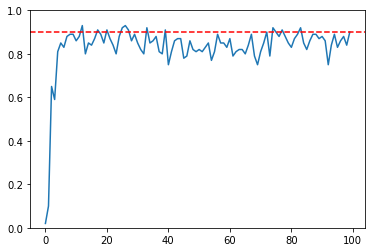

In [41]:
plt.plot(mean_rewards)
plt.ylim(0, 1)
plt.axhline(0.9, color='r', ls='--')